In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

c:\Users\Anthony\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### RNN Training

In this notebook, we will explore a new way to train our algorithm in the hope of having better results. Instead of using $x_{\text{True}}(t-1)$ to predict $x(t)$, we will use $x_{\text{True}}(t-1)$ to predict $x(t)$, and $x(t+1)$ ... all the way to $x(t+N)$. Let's begin by importing our functions. However, we will modify the way our system learn. let's begin by using a Truncated BPTT where $k_1=k_2$. Meaning every $k_1$, we will backpropagate taking $k_2$ steps.

In [2]:
def dydx(t,x,W, sigma, mu):
    '''Differential equation'''
    return -x + sigma(W @ x - mu)

def rnn(t, IC, dydx, W, sigma=lambda x: ((1+np.exp(-x))**(-1)), mu=0):
    '''Approximate RNN behaviors using RK4 numerical method
    -----------------------
    t : np.linspace()
        Time array
    IC : Line vector
        Initial condition
    dydx : Function
        Differential equation
    W : Matrix of shape (n_neuron x n_neuron)
        Weight matrix
    sigma : Function
        Activation function (sigmoid if unspecified)
    mu : float/int
        Activation threshold (0 if unspecified)
    ----------------------
    return result and dt
    '''
    n = len(IC)
    m = len(t)
    res = np.zeros((m, n))   #mxn matrix that contain our values
    res[0] = IC  # First line is redefine
    dt = (t[-1] - t[0])/m
    for i in range(1, m):
        k1 = dt * dydx(t[i-1], res[(i-1)], W=W, sigma=sigma, mu=mu)
        k2 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k1, W=W, sigma=sigma, mu=mu)
        k3 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k2, W=W, sigma=sigma, mu=mu)
        k4 = dt * dydx(t[i-1] + dt, res[(i-1)] + k3, W=W, sigma=sigma, mu=mu)
        res[i] = res[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return res, dt

In [3]:
def GenerateData(n_data, time, IC, W, ratio=0.6, mu=0, sigma=lambda x: (1+np.exp(-x))**(-1)):
    '''
    Generate fake data that follow a RNN function
    -------------------
    n_data : int
        Number of data per neuron
    time : float
        Time of our sample
    IC : Line 
        Initials conditions
    W : Square matrix with shape n_neurons x n_neurons
        Weight Matrix
    ratio : float or int ]0,1]
        Percentage of our fake data that will be use for training
    mu : float or int
        Activation threshold (0 if unspecified)
    sigma : function
        Non-linearities (sigmoid if unspecified)
    -------------------
    Return dict
    '''

    t = np.linspace(0, time, n_data)

    Slice = int(ratio * len(t))
    time_data = t[:Slice]
    Test_Data = np.array([])
    if ratio < 1:
        time_test = t[Slice:]
        Test_Data = rnn(t=time_test, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu).T

    Data, dt = rnn(t=time_data, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu)
    Data = Data.T

    out = {}
    out["Data"] = Data
    out["Test_Data"] = Test_Data
    out["W"] = W
    out["dt"] = dt
    out["mu"] = mu

    return out

In [4]:
def quality(n_neuron, true, train, num_max=1):
    '''
    Plot and identify the quality of the training
    ---------------------
    n_neuron : int
        Number of neurons in our system
    true : ndarray
        True value of our model
    train : ndarray
        Train model
    num_max : int
        Number of neurons with the worst loss function
    '''
    MSE_total = []

    for i in range(n_neuron):
        MSE = np.mean((train[:,i] - true[:,i])**2)
        MSE_total.append(MSE)

    plt.plot(np.linspace(1, n_neuron, n_neuron), MSE_total, "-")
    plt.xlabel("neuron")
    plt.ylabel("loss")
    plt.ylim([0,1])
    plt.show()

    worst = []

    for i, neuron in enumerate((sorted(MSE_total)[::-1])):
        if i < num_max:
            worst.append(MSE_total.index(neuron))

    return worst

In [70]:
class RNNModel(nn.Module):

    def __init__(self, W, dt, mu):
        super(RNNModel, self).__init__()
        self.W = W
        self.dt = dt
        self.mu = mu
    
    def forward(self, x):
        return x * (1-self.dt) + (torch.sigmoid(torch.matmul(self.W, x) - self.mu))*self.dt

Let's try the case where $k_1 = k_2$

If $K$ is big, than we backpropagate rarely but we do it on a bigger sample. If $K$ is small, then we backpropagate often but we dont get as far in time.

In [86]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN(n_neurons, x, dt, mu, K, lr=1, n_iters=500, g=1, momentum=0, verbose=False, loss_graph=False):
    '''
    Function that train our RNN to match a specific model
    ----------------------
    n_neurons : int
        Number of neurons in our RNN
    x : Matrix (n_data x n_neurons) np.array or torch.tensor
        Activity of neuron with their time step
    dt : float/int
        Delta_t (Euler's discretisation)
    mu : int/float
        Activity threshold (same for true data and predicted)
    lr : int/float
        learning rate(1 if unspecified)
    n_iters : int   
        number of iteration (epochs) (500 if unspecified)
    verbose : bool
        Update on epochs (False if unspecified)
    loss_graph : bool
        Plot loss function
    ----------------------
    return dict
    '''
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)

    dt = torch.tensor(dt, dtype=torch.float32)
    mu = torch.tensor(mu, dtype=torch.float32)
    
    #Set up
    #W = torch.zeros(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = g * torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify
    #dt = nn.Parameter(dt)
    #mu = nn.Parameter(mu)
    
    model = RNNModel(W=W, dt=dt, mu=mu)
    #optimizer = HessianFree(model.parameters())
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss = nn.MSELoss()

    #x_pred = torch.zeros(x.shape[0], x.shape[1])

    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()


    x_pred = torch.zeros(x.shape[0], x.shape[1])
    x_pred[0] = x[0]  #insert IC

    #Training
    for epoch in range(n_iters):
        for i in range(1, x.shape[0]):
            with torch.no_grad():
                x_pred_temp = x_pred[i-1].clone()
            
            x_pred[i] = model(x=x_pred_temp)
            
            if (i) % (K-1) == 0:  # We do the backpropagation

                l = loss(x_pred[(i-(K-1)):i], x[(i-(K-1)):i])

                #Backpropagate
                l.backward(retain_graph=True)

                optimizer.step()
                optimizer.zero_grad()
                

                if verbose :
                    with torch.no_grad():
                        y = x.detach().numpy()
                        y_pred = x_pred.detach().numpy()
                        print(f"epoch {epoch}/{n_iters} loss {l:.6f}")

    print(i)

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["x"] = x.detach().numpy()
    out["x_pred"] = x_pred.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out

Let's take $K=10$. By doing so, we compute 10 value, then we backpropagate on them. With 100 initials values, this should give an "OK" Value. However, by using **retain_graph=True**, we use a lot of memory which slow down the code by a lot

In [84]:
W = np.random.randn(2, 2)
IC = np.random.rand(2)

data = GenerateData(100, time=10, IC=IC, W=W, ratio=1)

In [87]:
pred = Train_RNN(2, data["Data"].T, data["dt"], data["mu"], K=10, lr=5, g=1, momentum=0.2, verbose=True, n_iters=20)

epoch 0/20 loss 0.001725
epoch 0/20 loss 0.006394
epoch 0/20 loss 0.008694
epoch 0/20 loss 0.009289
epoch 0/20 loss 0.009230
epoch 0/20 loss 0.008975
epoch 0/20 loss 0.008682
epoch 0/20 loss 0.008398
epoch 0/20 loss 0.008132
epoch 0/20 loss 0.007882
epoch 0/20 loss 0.007646
epoch 1/20 loss 0.001271
epoch 1/20 loss 0.004693
epoch 1/20 loss 0.006363
epoch 1/20 loss 0.006801
epoch 1/20 loss 0.006778
epoch 1/20 loss 0.006617
epoch 1/20 loss 0.006428
epoch 1/20 loss 0.006244
epoch 1/20 loss 0.006069
epoch 1/20 loss 0.005903
epoch 1/20 loss 0.005745
epoch 2/20 loss 0.000950
epoch 2/20 loss 0.003513
epoch 2/20 loss 0.004781
epoch 2/20 loss 0.005134
epoch 2/20 loss 0.005138
epoch 2/20 loss 0.005035
epoch 2/20 loss 0.004907
epoch 2/20 loss 0.004779
epoch 2/20 loss 0.004655
epoch 2/20 loss 0.004538
epoch 2/20 loss 0.004425
epoch 3/20 loss 0.000720
epoch 3/20 loss 0.002671
epoch 3/20 loss 0.003655
epoch 3/20 loss 0.003948
epoch 3/20 loss 0.003971
epoch 3/20 loss 0.003905
epoch 3/20 loss 0.003816


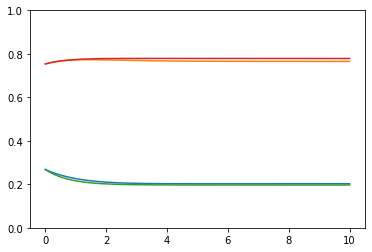

In [88]:
t = np.linspace(0, 10, 1000)
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]

plt.plot(t, train, label="Train")
plt.plot(t, true, label="True")
plt.ylim([0,1])
plt.show()

Let's now use $K=100$

In [89]:
pred = Train_RNN(2, data["Data"].T, data["dt"], data["mu"], K=100, lr=5, g=1, momentum=0.5, verbose=True, n_iters=20)

epoch 0/20 loss 0.087142
epoch 1/20 loss 0.082721
epoch 2/20 loss 0.076404
epoch 3/20 loss 0.069549
epoch 4/20 loss 0.062842
epoch 5/20 loss 0.056605
epoch 6/20 loss 0.050960
epoch 7/20 loss 0.045926
epoch 8/20 loss 0.041474
epoch 9/20 loss 0.037551
epoch 10/20 loss 0.034098
epoch 11/20 loss 0.031057
epoch 12/20 loss 0.028374
epoch 13/20 loss 0.026000
epoch 14/20 loss 0.023894
epoch 15/20 loss 0.022019
epoch 16/20 loss 0.020345
epoch 17/20 loss 0.018844
epoch 18/20 loss 0.017495
epoch 19/20 loss 0.016279
99


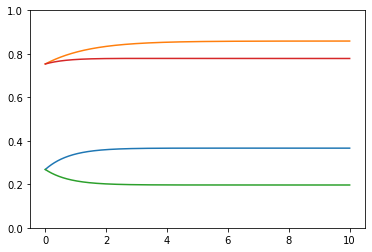

In [90]:
t = np.linspace(0, 10, 1000)
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]

plt.plot(t, train, label="Train")
plt.plot(t, true, label="True")
plt.ylim([0,1])
plt.show()

Let's try with a bigger sample:

In [92]:
IC = np.random.rand(172)
W = 3*np.random.randn(172, 172)

data = GenerateData(500, time=20, IC=IC, W=W, ratio=1)

In [93]:
import time
start = time.time()
pred = Train_RNN(172, data["Data"].T, data["dt"], data["mu"], K=10, lr=5, g=1, momentum=0.5, verbose=True, n_iters=7)
end = time.time()
print(end-start)

epoch 0/7 loss 0.013030
epoch 0/7 loss 0.072157
epoch 0/7 loss 0.137633
epoch 0/7 loss 0.193707
epoch 0/7 loss 0.243480
epoch 0/7 loss 0.287750
epoch 0/7 loss 0.326696
epoch 0/7 loss 0.360780
epoch 0/7 loss 0.387899
epoch 0/7 loss 0.408566
epoch 0/7 loss 0.422877
epoch 0/7 loss 0.431668
epoch 0/7 loss 0.435850
epoch 0/7 loss 0.436510
epoch 0/7 loss 0.436655
epoch 0/7 loss 0.436250
epoch 0/7 loss 0.433211
epoch 0/7 loss 0.427759
epoch 0/7 loss 0.422333
epoch 0/7 loss 0.419482
epoch 0/7 loss 0.419550
epoch 0/7 loss 0.421159
epoch 0/7 loss 0.422695
epoch 0/7 loss 0.423307
epoch 0/7 loss 0.422143
epoch 0/7 loss 0.418631
epoch 0/7 loss 0.413627
epoch 0/7 loss 0.410033
epoch 0/7 loss 0.407547
epoch 0/7 loss 0.405985
epoch 0/7 loss 0.407147
epoch 0/7 loss 0.410169
epoch 0/7 loss 0.413570
epoch 0/7 loss 0.416663
epoch 0/7 loss 0.418908
epoch 0/7 loss 0.420040
epoch 0/7 loss 0.420097
epoch 0/7 loss 0.419294
epoch 0/7 loss 0.418093
epoch 0/7 loss 0.417119
epoch 0/7 loss 0.416713
epoch 0/7 loss 0

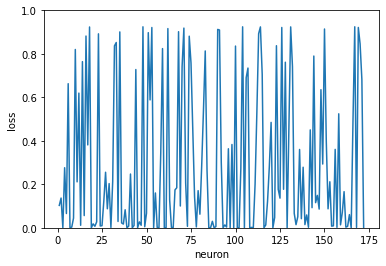

[166, 47, 103]

In [95]:
t = np.linspace(0, 20, 1000)
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]

qual = quality(172, true, train, 3)
qual

In [97]:
import time
start = time.time()
pred = Train_RNN(172, data["Data"].T, data["dt"], data["mu"], K=500, lr=5, g=1, momentum=0.9, verbose=True, n_iters=15)
end = time.time()
print(end-start)

epoch 0/15 loss 0.417651
epoch 1/15 loss 0.417200
epoch 2/15 loss 0.416334
epoch 3/15 loss 0.415075
epoch 4/15 loss 0.413411
epoch 5/15 loss 0.411279
epoch 6/15 loss 0.408487
epoch 7/15 loss 0.404442
epoch 8/15 loss 0.399002
epoch 9/15 loss 0.396784
epoch 10/15 loss 0.396463
epoch 11/15 loss 0.395672
epoch 12/15 loss 0.394272
epoch 13/15 loss 0.392218
epoch 14/15 loss 0.389796
499
12.247732639312744


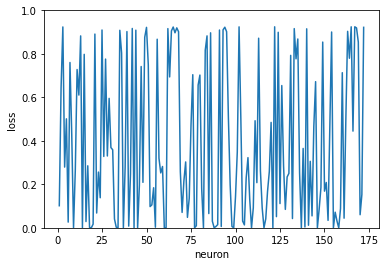

[166, 121, 164]

In [99]:
t = np.linspace(0, 20, 1000)
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
qual = quality(172, true, train, 3)
qual

-----------------------------

Let's modify our code. We will still use the case where $k_1 = k_2$. However, we will use a different approach in order to fix the problem of retaining graph of gradient. Instead of creating the entire set, we only create the set for our batch. Therefore, we don't have to retain the graph.

In [100]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN(n_neurons, x, dt, mu, K, lr=1, n_iters=500, g=1, momentum=0, verbose=False, loss_graph=False):
    '''
    Function that train our RNN to match a specific model
    ----------------------
    n_neurons : int
        Number of neurons in our RNN
    x : Matrix (n_data x n_neurons) np.array or torch.tensor
        Activity of neuron with their time step
    dt : float/int
        Delta_t (Euler's discretisation)
    mu : int/float
        Activity threshold (same for true data and predicted)
    lr : int/float
        learning rate(1 if unspecified)
    n_iters : int   
        number of iteration (epochs) (500 if unspecified)
    verbose : bool
        Update on epochs (False if unspecified)
    loss_graph : bool
        Plot loss function
    ----------------------
    return dict
    '''
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)

    dt = torch.tensor(dt, dtype=torch.float32)
    mu = torch.tensor(mu, dtype=torch.float32)
    
    #Set up
    #W = torch.zeros(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = g * torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify
    #dt = nn.Parameter(dt)
    #mu = nn.Parameter(mu)
    
    model = RNNModel(W=W, dt=dt, mu=mu)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss = nn.MSELoss()

    #x_pred = torch.zeros(x.shape[0], x.shape[1])

    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()


    x_pred = torch.zeros(x.shape[0], x.shape[1])
    previous = x[0]

    batch_size = int(x.shape[0] / K)


    #Training
    for epoch in range(n_iters):
        for batch in range(K):

            x_pred = torch.zeros(batch_size, x.shape[1], dtype=torch.float32)
            x_pred[0] = previous

            for i in range(1, batch_size):
                with torch.no_grad():
                    x_pred_temp = x_pred[i-1].clone()

                x_pred[i] = model(x_pred_temp)

                #l += loss(x_pred[i], x[(batch_size*batch+i)])

                if (i) == (batch_size - 1):  # We do the backpropagation
                    

                        
                    x_compare = x[(batch_size * batch):(batch_size * batch + batch_size)][1:]
                    x_pred_compare = x_pred[1:]



                    l = loss(x_pred_compare, x_compare)

                    #l = 1/batch_size * l

                    #Backpropagate
                    l.backward(retain_graph=False)

                    optimizer.step()
                    optimizer.zero_grad()

                    


                    previous = x[(batch_size * batch + batch_size) - 1]

                    

                    if verbose :
                        with torch.no_grad():
                            y = x.detach().numpy()
                            y_pred = x_pred.detach().numpy()
                            print(f"epoch {epoch}/{n_iters} loss {l:.6f}")
                    l=0


    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["x"] = x.detach().numpy()
    out["x_pred"] = x_pred.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out

Let's use a small $K$, such as $K=5$

In [58]:
W = 8*np.random.randn(2,2)
IC = np.random.rand(2)

data = GenerateData(500, 20, IC=IC, W=W, ratio=1)

In [60]:
pred = Train_RNN(2, data["Data"].T, data["dt"], data["mu"], K=5, lr=20, n_iters=40, g=1, momentum=0.5, verbose=True)

epoch 0/40 loss 0.117384
epoch 0/40 loss 0.069289
epoch 0/40 loss 0.065640
epoch 0/40 loss 0.062034
epoch 0/40 loss 0.058632
epoch 1/40 loss 0.068877
epoch 1/40 loss 0.052606
epoch 1/40 loss 0.049982
epoch 1/40 loss 0.047560
epoch 1/40 loss 0.045334
epoch 2/40 loss 0.056163
epoch 2/40 loss 0.041409
epoch 2/40 loss 0.039683
epoch 2/40 loss 0.038069
epoch 2/40 loss 0.036567
epoch 3/40 loss 0.047649
epoch 3/40 loss 0.033870
epoch 3/40 loss 0.032665
epoch 3/40 loss 0.031523
epoch 3/40 loss 0.030448
epoch 4/40 loss 0.041608
epoch 4/40 loss 0.028492
epoch 4/40 loss 0.027606
epoch 4/40 loss 0.026758
epoch 4/40 loss 0.025953
epoch 5/40 loss 0.037111
epoch 5/40 loss 0.024472
epoch 5/40 loss 0.023796
epoch 5/40 loss 0.023143
epoch 5/40 loss 0.022519
epoch 6/40 loss 0.033637
epoch 6/40 loss 0.021361
epoch 6/40 loss 0.020828
epoch 6/40 loss 0.020310
epoch 6/40 loss 0.019813
epoch 7/40 loss 0.030874
epoch 7/40 loss 0.018884
epoch 7/40 loss 0.018454
epoch 7/40 loss 0.018034
epoch 7/40 loss 0.017628


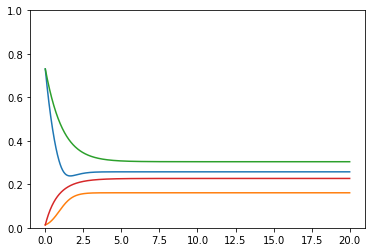

In [61]:
t = np.linspace(0, 20, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, true)
plt.plot(t, train)
plt.ylim([0,1])
plt.show()

Now, let's use a bigger $K$ such as $K=250$

In [62]:
pred = Train_RNN(2, data["Data"].T, data["dt"], data["mu"], K=250, lr=20, n_iters=40, g=1, momentum=0.5, verbose=True)

epoch 0/40 loss 0.000237
epoch 0/40 loss 0.000957
epoch 0/40 loss 0.000880
epoch 0/40 loss 0.000810
epoch 0/40 loss 0.000746
epoch 0/40 loss 0.000687
epoch 0/40 loss 0.000630
epoch 0/40 loss 0.000577
epoch 0/40 loss 0.000524
epoch 0/40 loss 0.000471
epoch 0/40 loss 0.000417
epoch 0/40 loss 0.000364
epoch 0/40 loss 0.000312
epoch 0/40 loss 0.000264
epoch 0/40 loss 0.000222
epoch 0/40 loss 0.000186
epoch 0/40 loss 0.000159
epoch 0/40 loss 0.000138
epoch 0/40 loss 0.000124
epoch 0/40 loss 0.000115
epoch 0/40 loss 0.000110
epoch 0/40 loss 0.000107
epoch 0/40 loss 0.000107
epoch 0/40 loss 0.000108
epoch 0/40 loss 0.000110
epoch 0/40 loss 0.000112
epoch 0/40 loss 0.000114
epoch 0/40 loss 0.000117
epoch 0/40 loss 0.000119
epoch 0/40 loss 0.000122
epoch 0/40 loss 0.000124
epoch 0/40 loss 0.000126
epoch 0/40 loss 0.000128
epoch 0/40 loss 0.000130
epoch 0/40 loss 0.000131
epoch 0/40 loss 0.000133
epoch 0/40 loss 0.000134
epoch 0/40 loss 0.000135
epoch 0/40 loss 0.000136
epoch 0/40 loss 0.000136


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


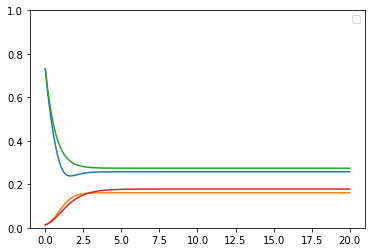

In [63]:
t = np.linspace(0, 20, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]
untrain = rnn(t=t, IC=IC, dydx=dydx, W=pred["W0"])[0]

plt.plot(t, true)
plt.plot(t, train)
#plt.plot(t, untrain, label="Untrain")
plt.legend()
plt.ylim([0,1])
plt.show()

Now the more complicated test .... $n=172$ with 1000 datas points

In [64]:
W = 5*np.random.randn(172, 172)
IC = np.random.rand(172)

data = GenerateData(2000, 30, IC=IC, W=W, ratio=1)

In [65]:
pred = Train_RNN(172, data["Data"].T, data["dt"], data["mu"], K=1000, lr=20, n_iters=40, g=1, momentum=0.5, verbose=True)

epoch 0/40 loss 0.000100
epoch 0/40 loss 0.000279
epoch 0/40 loss 0.000273
epoch 0/40 loss 0.000265
epoch 0/40 loss 0.000257
epoch 0/40 loss 0.000250
epoch 0/40 loss 0.000243
epoch 0/40 loss 0.000236
epoch 0/40 loss 0.000231
epoch 0/40 loss 0.000227
epoch 0/40 loss 0.000224
epoch 0/40 loss 0.000220
epoch 0/40 loss 0.000217
epoch 0/40 loss 0.000215
epoch 0/40 loss 0.000214
epoch 0/40 loss 0.000211
epoch 0/40 loss 0.000208
epoch 0/40 loss 0.000205
epoch 0/40 loss 0.000203
epoch 0/40 loss 0.000199
epoch 0/40 loss 0.000196
epoch 0/40 loss 0.000192
epoch 0/40 loss 0.000188
epoch 0/40 loss 0.000186
epoch 0/40 loss 0.000184
epoch 0/40 loss 0.000182
epoch 0/40 loss 0.000180
epoch 0/40 loss 0.000178
epoch 0/40 loss 0.000177
epoch 0/40 loss 0.000175
epoch 0/40 loss 0.000174
epoch 0/40 loss 0.000172
epoch 0/40 loss 0.000169
epoch 0/40 loss 0.000167
epoch 0/40 loss 0.000165
epoch 0/40 loss 0.000162
epoch 0/40 loss 0.000160
epoch 0/40 loss 0.000159
epoch 0/40 loss 0.000159
epoch 0/40 loss 0.000157


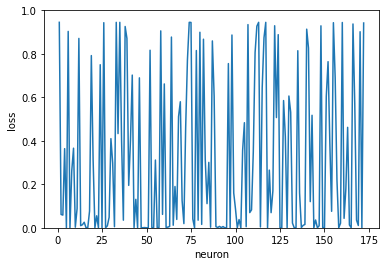

[73, 112, 0]

In [66]:
t = np.linspace(0, 30, 100)

true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

qual = quality(172, true, train, 3)
qual

In [69]:
pred = Train_RNN(172, data["Data"].T, data["dt"], data["mu"], K=5, lr=20, n_iters=60, g=1, momentum=0.5, verbose=True)

epoch 0/60 loss 0.303328
epoch 0/60 loss 0.299714
epoch 0/60 loss 0.315235
epoch 0/60 loss 0.299231
epoch 0/60 loss 0.299241
epoch 1/60 loss 0.308924
epoch 1/60 loss 0.296644
epoch 1/60 loss 0.310902
epoch 1/60 loss 0.296350
epoch 1/60 loss 0.295835
epoch 2/60 loss 0.306176
epoch 2/60 loss 0.293413
epoch 2/60 loss 0.306537
epoch 2/60 loss 0.293486
epoch 2/60 loss 0.292709
epoch 3/60 loss 0.303374
epoch 3/60 loss 0.290310
epoch 3/60 loss 0.302462
epoch 3/60 loss 0.290828
epoch 3/60 loss 0.289803
epoch 4/60 loss 0.300563
epoch 4/60 loss 0.287242
epoch 4/60 loss 0.298724
epoch 4/60 loss 0.288378
epoch 4/60 loss 0.287069
epoch 5/60 loss 0.297775
epoch 5/60 loss 0.284226
epoch 5/60 loss 0.295263
epoch 5/60 loss 0.286082
epoch 5/60 loss 0.284506
epoch 6/60 loss 0.295032
epoch 6/60 loss 0.281325
epoch 6/60 loss 0.291986
epoch 6/60 loss 0.283935
epoch 6/60 loss 0.282115
epoch 7/60 loss 0.292329
epoch 7/60 loss 0.278539
epoch 7/60 loss 0.288830
epoch 7/60 loss 0.281998
epoch 7/60 loss 0.279882


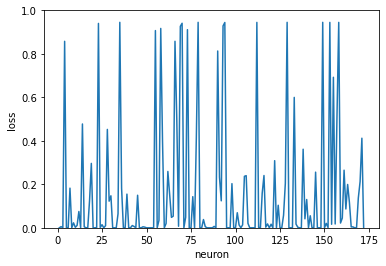

[148, 128, 78]

In [239]:
t = np.linspace(0, 30, 100)

true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

qual = quality(172, true, train, 3)
qual